In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import r2_score

import numpy as np

from tqdm import tqdm
from datetime import timedelta  

import warnings
warnings.filterwarnings(action='ignore')

In [30]:
def plot_line(df, title):
    fig = px.line(df, x = 'date', y = 'count', title = title)
    fig.show()
    
def filter_column(df, column, border_low, border_high):
    filter_mask = (df[column] >= border_low) & (df[column] < border_high)
    
    filtered_df = df[filter_mask].reset_index(drop=True)
    return filtered_df

def convert_columns(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

def plot_prediction(total, pred, test, title):
    r2 = r2_score(test, pred)
    predict_index = list(pred.index)

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(total);

    ax.vlines(test.index[0], 0, 100000, linestyle='--', color = 'r', label ='Start of Forecast')
    
    ax.plot(predict_index, pred.values, label = 'Prediction')

    # ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

    ax.legend(loc = 'upper left')

    plt.suptitle(f'{title} Prediction Results (r2_score: {round(r2, 2)})')
    plt.show()
    
def plot_multi_prediction(total, pred, test):
    
    predict_index = list(pred[0][0].index)

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(total);

    ax.vlines(predict_index[0], 0, 100000, linestyle='--', color = 'r', label ='Start of Forecast')
    
    for p in pred:
        ax.plot(predict_index, p[0].values, label = p[1])

    # ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

    ax.legend(loc = 'upper left')

    plt.show()

In [31]:
train_data = pd.read_csv("../dataset/train_test/train.csv")
test_data = pd.read_csv("../dataset/train_test/test.csv")

train_data = train_data[['date', 'count']]
test_data = test_data[['date', 'count']]

data = pd.concat([train_data, test_data])

data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')

test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

In [32]:
data = data[data.index > '2019-12-31']

In [33]:
arima_plot = pd.read_csv("../dataset/results/arima/arima_plot.csv")

arima_plot = arima_plot[['date', 'count']]
arima_plot = convert_columns(arima_plot)

arima_plot = arima_plot[arima_plot.index >= '2020-03-01']

In [34]:
sarima_plot = pd.read_csv("../dataset/results/arima/sarima_plot.csv")

sarima_plot = sarima_plot[['date', 'count']]
sarima_plot = convert_columns(sarima_plot)

sarima_plot = sarima_plot[sarima_plot.index >= '2020-03-01']

In [37]:
ARIMA_LIST = [(arima_plot, 'ARIMA'), (sarima_plot, 'SARIMA')]

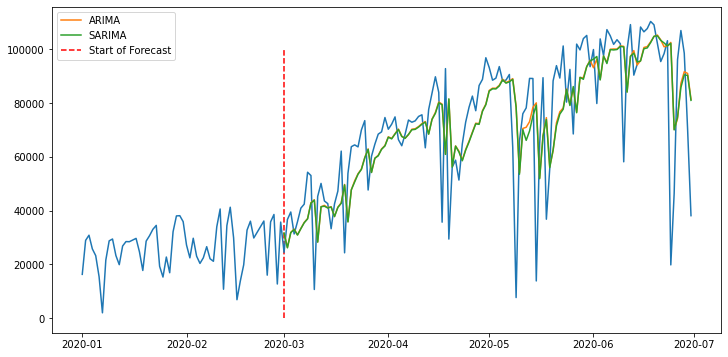

In [38]:
plot_multi_prediction(data, ARIMA_LIST, test_data)

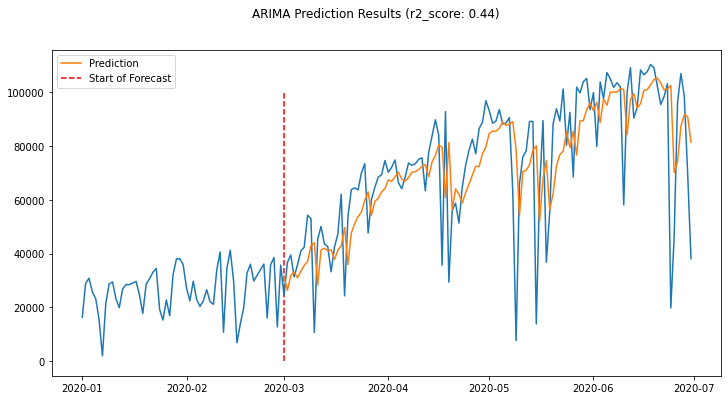

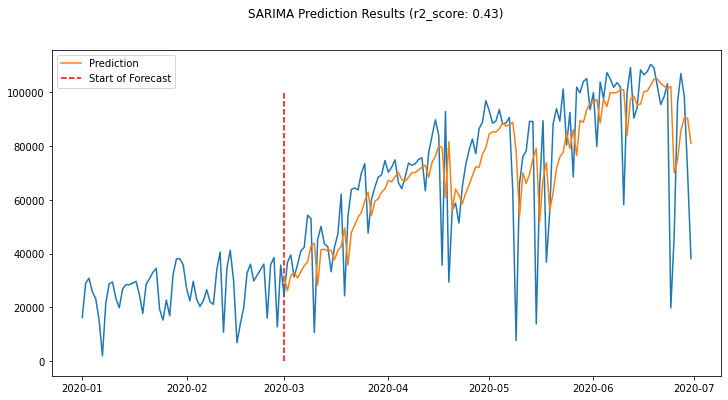

In [14]:
plot_prediction(data, arima_plot, test_data, 'ARIMA')
plot_prediction(data, sarima_plot, test_data, 'SARIMA')

In [15]:
lstm_plot = pd.read_csv("../dataset/results/lstm/lstm_plot.csv")

lstm_plot = lstm_plot[['date', 'predict']]
lstm_plot = convert_columns(lstm_plot)

lstm_plot = lstm_plot[lstm_plot.index >= '2020-03-01']

In [16]:
svr_plot = pd.read_csv("../dataset/results/svr/svr_summary.csv")

svr_plot = svr_plot[['date', 'predict']]
svr_plot = convert_columns(svr_plot)

svr_plot = svr_plot[svr_plot.index >= '2020-03-01']

In [17]:
old_plot = pd.read_excel("../dataset/results/residuals/old_summary.xlsx")

old_plot = convert_columns(old_plot)
old_plot = old_plot[old_plot.index >= '2020-03-01']

In [18]:
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def mean_absolute_percentage_error(y_true, y_pred): 
    return ((np.mean(np.abs((y_true - y_pred) / y_true)) * 100).values[0])

def smape(A, F):
    return (100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))).values[0]

def all_metric(y_true, y_pred):
    print(f'r2 score: {r2_score(y_true, y_pred)}')
    print(f'Mean Absolute Error: {mae(y_true, y_pred)}')
    print(f'Mean Squared Error: {mse(y_true, y_pred)}')
    print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'SMAPE: {smape(y_true, y_pred)}')

In [19]:
all_metric(test_data, lstm_plot['predict'])

r2 score: 0.8826735051699347
Mean Absolute Error: 6270.7067140673025
Mean Squared Error: 73774267.07559869
Mean Absolute Percentage Error: nan
SMAPE: 0.0


In [20]:
average_mean = old_plot['구간평균법']
trigonometric = old_plot['trigonometric']
simple_exp = old_plot['simple exponential smoothing']
double_exp = old_plot['double exponential smoothing']
additive_holt = old_plot['additive holt winters']
multiple_holt = old_plot['multiplicative holt winters']
linear = old_plot['linear']

In [21]:
model_list = [
    (average_mean, "Moving Average"),
    (trigonometric, 'Trigonometric'),
    (simple_exp,'Simple exponential smoothing'),
    (double_exp,'Double exponential smoothing'),
    (additive_holt,'Additive holt winters'),
    (multiple_holt,'Multiplicative holt winters'),
    (linear,'Linear')
]

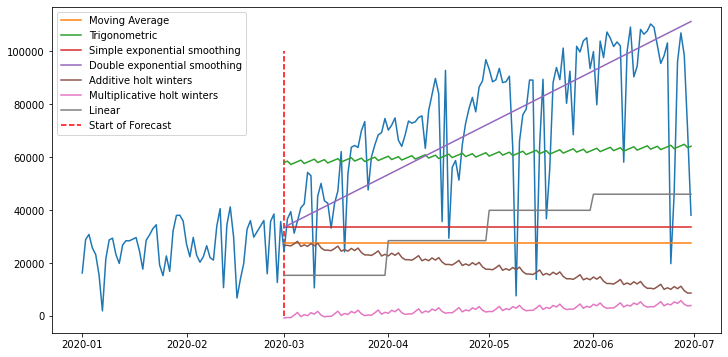

In [39]:
plot_multi_prediction(data, model_list, test_data)

In [40]:
lstm_svr = [(lstm_plot, 'LSTM'), (svr_plot, 'SVR')]

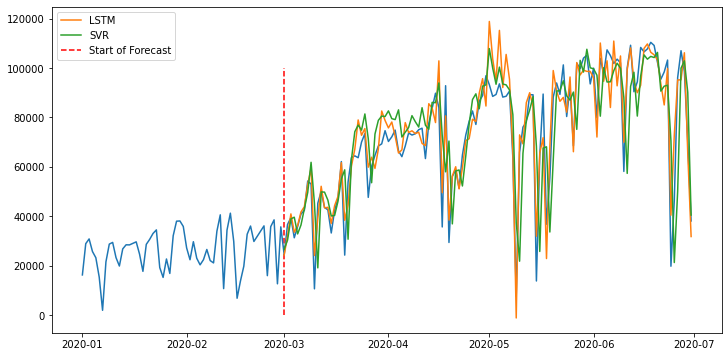

In [41]:
plot_multi_prediction(data, lstm_svr , test_data)

In [92]:
lstm_result = pd.read_csv('../dataset/results/lstm/lstm_result.csv')
svr_result = pd.read_csv('../dataset/results/svr/svr_result.csv')
old_result = pd.read_excel('../dataset/results/residuals/old_result.xlsx')

In [93]:
lstm_result

,date,learning_rate,window_size,mse,mae,mape,smape
0,12-1 14:34,0.001,3,75437100.0,6376.3076,12.594271,11.821646


In [94]:
old_result

,Unnamed: 0,trigonometric,구간평균법(5),simple exponential smoothing,double exponential smoothing,additive Holt-Winters,Multiplicative Holt-Winters,linear
0,AIC,2.491213e+03,2.651701e+03,1.873908e+03,2.434523e+03,2.693722e+03,2.740769e+03,2.619560e+03
1,r_square,-1.549600e-01,-3.304030e+00,9.926700e-01,2.742900e-01,-5.073760e+00,-7.931760e+00,-2.307170e+00
2,mae,2.317342e+04,4.665994e+04,1.365331e+03,1.408642e+04,5.527890e+04,7.091069e+04,4.258266e+04
3,mape,4.427002e+01,6.139983e+01,3.715050e+00,3.261720e+01,7.077704e+01,9.636145e+01,6.107573e+01
4,smape,3.519411e+01,8.600544e+01,3.298050e+00,2.495536e+01,1.123023e+02,1.862649e+02,8.122070e+01
5,mse,7.262351e+08,2.706350e+09,4.608952e+06,4.563238e+08,3.819150e+09,5.616240e+09,2.079528e+09


In [95]:
svr_result

,date,mse,mae,mape,smape
0,12-1 14:1,2.842415e+08,11750.335303,28.167379,20.598302
